# Fushion of IMU and Audio features

## Training on augmented datasets: 1000ms augmentation case.
- Training is done by including: 1-shift (50ms), 2-shifts (100ms), 10-shifts (500ms), 20-shifts (1000ms)

## IMU and Audio data is concatenated at an intermediate layer and then prediction is made

In [1]:
import numpy as np
import scipy.io

from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint


import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

from matplotlib import pyplot as plt
from PIL import Image as img_PIL


# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tensorflow import set_random_seed
set_random_seed(rand_seed)

Using TensorFlow backend.
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nesl/anaconda3/envs/py36/l

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=7

    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='data/'


def get_train_data(path=path):
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_valid_data(path=path):
    Train_data=np.load(path+'valid_1000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_test_data(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound


In [4]:
Features_imu1,Labels1,Features_sound1 = get_train_data()
print(Features_imu1.shape, Labels1.shape, Features_sound1.shape)
print('Train Classes distribution: ',np.sum(Labels1, axis =0))

Features_imu2,Labels2,Features_sound2 = get_valid_data()
print(Features_imu2.shape, Labels2.shape, Features_sound2.shape)
print('Valid Classes distribution: ',np.sum(Labels2, axis =0))

Features_imu3,Labels3,Features_sound3 = get_test_data()
print(Features_imu3.shape, Labels3.shape, Features_sound3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis =0))

(5000, 1, 40, 12) (5000, 7) (5000, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 656.]
(1000, 1, 40, 12) (1000, 7) (1000, 193)
Valid Classes distribution:  [150. 188. 136. 141.  98. 157. 130.]
(1377, 1, 40, 12) (1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


In [5]:
def get_train_data2(path,file):
    Train_data=np.load(path+file)
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']
    return Features_imu,Labels,Features_sound


In [6]:
Features_imu_1,Labels_1,Features_sound_1 = get_train_data2(path,'train_data_1_shift.npz')
print(Features_imu_1.shape, Labels_1.shape, Features_sound_1.shape)
print('Train Classes distribution: ',np.sum(Labels_1, axis =0))

(4999, 1, 40, 12) (4999, 7) (4999, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 655.]


In [7]:
Features_imu_2,Labels_2,Features_sound_2 = get_train_data2(path,'train_data_2_shift.npz')
print(Features_imu_2.shape, Labels_2.shape, Features_sound_2.shape)
print('Train Classes distribution: ',np.sum(Labels_2, axis =0))

(4999, 1, 40, 12) (4999, 7) (4999, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 655.]


In [8]:
Features_imu_10,Labels_10,Features_sound_10 = get_train_data2(path,'train_data_10_shift.npz')
print(Features_imu_10.shape, Labels_10.shape, Features_sound_10.shape)
print('Train Classes distribution: ',np.sum(Labels_10, axis =0))

(4999, 1, 40, 12) (4999, 7) (4999, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 655.]


In [9]:
Features_imu_20,Labels_20,Features_sound_20 = get_train_data2(path,'train_data_20_shift.npz')
print(Features_imu_20.shape, Labels_20.shape, Features_sound_20.shape)
print('Train Classes distribution: ',np.sum(Labels_20, axis =0))

(4999, 1, 40, 12) (4999, 7) (4999, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 655.]


# Make augmented Training Data

In [10]:
Features_imu = np.concatenate((Features_imu1,Features_imu_1,Features_imu_2,Features_imu_10,Features_imu_20),axis=0)
Features_imu.shape

(24996, 1, 40, 12)

In [11]:
Labels = np.concatenate((Labels1,Labels_1,Labels_2,Labels_10,Labels_20),axis=0)
Labels.shape

(24996, 7)

In [12]:
Features_sound = np.concatenate((Features_sound1,Features_sound_1,Features_sound_2,Features_sound_10,Features_sound_20),axis=0)
Features_sound.shape

(24996, 193)

In [13]:
model_path = 'data/IMU_Audio_Fusion_1000ms'

# Combined Model: Audio + IMU

In [14]:
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tensorflow import set_random_seed
set_random_seed(rand_seed)

input_audio = keras.layers.Input(shape=(193,))
A1 = keras.layers.Dense(256, activation='relu')(input_audio)
A2 = keras.layers.Dense(256, activation='relu')(A1)
D1 = keras.layers.Dropout(0.3)(A2)
A5 = keras.layers.Dense(128, activation='relu')(D1)



num_feat_map=32
_, dim, win_len, _, = Features_imu.shape
input_imu = keras.layers.Input(shape=(dim, win_len, 12))

I1 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(input_imu)
I2=keras.layers.MaxPooling2D(pool_size=(1, 2))(I1)

I3 = keras.layers.Conv2D(num_feat_map, kernel_size=(1, 5),
                 activation='relu',
                 padding='same')(I2)
I4=keras.layers.MaxPooling2D(pool_size=(1, 2))(I3)
I5=keras.layers.Flatten()(I4)

I6= keras.layers.Dense(256, activation='relu')(I5)
D2 = keras.layers.Dropout(0.3)(I6)

I7= keras.layers.Dense(128, activation='relu')(D2)


# equivalent to added = keras.layers.add([x1, x2])
C1 =keras.layers.concatenate([A5, I7], axis=-1)


C3= keras.layers.Dense(64, activation='relu')(C1)

out = keras.layers.Dense(7, activation='softmax')(C3)

model = keras.models.Model(inputs=[input_audio, input_imu], outputs=out)
#model = keras.models.Model(inputs=input_audio, outputs=out)


In [15]:
#model.summary()

In [16]:



from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath=model_path, verbose=1,monitor='val_acc' ,save_best_only=True, save_weights_only=False)

In [17]:
batch_size = 128
epochs = 100
from keras import optimizers
from keras.optimizers import Adam

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= adam,
              metrics=['accuracy'])

import time
start_time = time.time()

learning_hist = model.fit([Features_sound,Features_imu], Labels,
                    verbose=1,
                    epochs=epochs,
                        shuffle=True,
                    batch_size=batch_size,
                        callbacks=[checkpointer],
                    validation_data=([Features_sound2,Features_imu2], Labels2)
                         
                         )

end_time = time.time()

print("---Time %s seconds ---" % (end_time - start_time))

Train on 24996 samples, validate on 1000 samples
Epoch 1/100
24996/24996 [==============================] - 40s 2ms/step - loss: 3.4956 - acc: 0.6727 - val_loss: 0.2626 - val_acc: 0.9260

Epoch 00001: val_acc improved from -inf to 0.92600, saving model to data/IMU_Audio_Fusion_1000ms
Epoch 2/100
24996/24996 [==============================] - 36s 1ms/step - loss: 0.1964 - acc: 0.9322 - val_loss: 0.1321 - val_acc: 0.9640

Epoch 00002: val_acc improved from 0.92600 to 0.96400, saving model to data/IMU_Audio_Fusion_1000ms
Epoch 3/100
24996/24996 [==============================] - 36s 1ms/step - loss: 0.1112 - acc: 0.9582 - val_loss: 0.0998 - val_acc: 0.9710

Epoch 00003: val_acc improved from 0.96400 to 0.97100, saving model to data/IMU_Audio_Fusion_1000ms
Epoch 4/100
24996/24996 [==============================] - 25s 1ms/step - loss: 0.0720 - acc: 0.9728 - val_loss: 0.1093 - val_acc: 0.9680

Epoch 00004: val_acc did not improve from 0.97100
Epoch 5/100
24996/24996 [=======================


Epoch 00040: val_acc did not improve from 0.99200
Epoch 41/100
24996/24996 [==============================] - 11s 440us/step - loss: 0.0201 - acc: 0.9952 - val_loss: 0.1135 - val_acc: 0.9840

Epoch 00041: val_acc did not improve from 0.99200
Epoch 42/100
24996/24996 [==============================] - 11s 437us/step - loss: 0.0090 - acc: 0.9971 - val_loss: 0.0773 - val_acc: 0.9890

Epoch 00042: val_acc did not improve from 0.99200
Epoch 43/100
24996/24996 [==============================] - 11s 450us/step - loss: 0.0072 - acc: 0.9983 - val_loss: 0.1133 - val_acc: 0.9820

Epoch 00043: val_acc did not improve from 0.99200
Epoch 44/100
24996/24996 [==============================] - 12s 476us/step - loss: 0.0177 - acc: 0.9963 - val_loss: 0.0959 - val_acc: 0.9800

Epoch 00044: val_acc did not improve from 0.99200
Epoch 45/100
24996/24996 [==============================] - 12s 465us/step - loss: 0.0037 - acc: 0.9989 - val_loss: 0.0819 - val_acc: 0.9880

Epoch 00045: val_acc did not improve fr

24996/24996 [==============================] - 22s 866us/step - loss: 0.0191 - acc: 0.9968 - val_loss: 0.1168 - val_acc: 0.9850

Epoch 00083: val_acc did not improve from 0.99200
Epoch 84/100
24996/24996 [==============================] - 21s 852us/step - loss: 0.0170 - acc: 0.9972 - val_loss: 0.1768 - val_acc: 0.9820

Epoch 00084: val_acc did not improve from 0.99200
Epoch 85/100
24996/24996 [==============================] - 21s 836us/step - loss: 0.0325 - acc: 0.9959 - val_loss: 0.1659 - val_acc: 0.9780

Epoch 00085: val_acc did not improve from 0.99200
Epoch 86/100
24996/24996 [==============================] - 21s 831us/step - loss: 0.0087 - acc: 0.9984 - val_loss: 0.1610 - val_acc: 0.9820

Epoch 00086: val_acc did not improve from 0.99200
Epoch 87/100
24996/24996 [==============================] - 21s 837us/step - loss: 0.0131 - acc: 0.9976 - val_loss: 0.2159 - val_acc: 0.9750

Epoch 00087: val_acc did not improve from 0.99200
Epoch 88/100
24996/24996 [===========================

# Accuracies

In [18]:
model.evaluate([Features_sound3,Features_imu3],Labels3)


1377/1377 [==============================] - 1s 475us/step


[0.17568565193563748, 0.971677559912854]

In [19]:
from keras.models import load_model

model_fused = load_model(model_path)

In [20]:
#Train Accuracy
model_fused.evaluate([Features_sound,Features_imu],Labels)

24996/24996 [==============================] - 11s 434us/step


[0.006903310225479172, 0.9977596415426468]

In [21]:
## Valid Accuracy
model_fused.evaluate([Features_sound2,Features_imu2],Labels2)

1000/1000 [==============================] - 0s 414us/step


[0.05038352374028546, 0.992]

In [22]:
## Test Accuracy
model_fused.evaluate([Features_sound3,Features_imu3],Labels3)

1377/1377 [==============================] - 1s 417us/step


[0.10806767817294642, 0.9724037763253449]

# Plotting

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


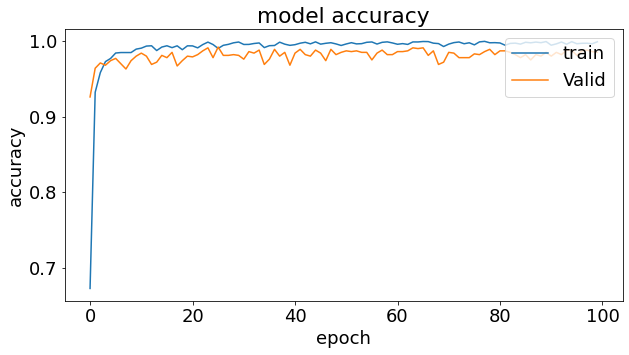

In [23]:
from matplotlib import pyplot as plt

print(learning_hist.history.keys())
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(10,5))

plt.plot(learning_hist.history['acc'])
plt.plot(learning_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()

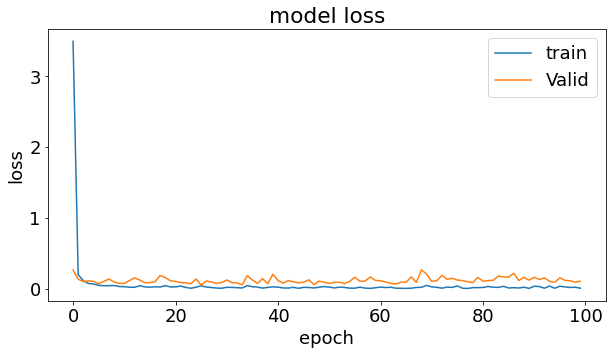

In [24]:
# summarize history for loss

from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})


plt.plot(learning_hist.history['loss'])
plt.plot(learning_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Valid'], loc='upper right')
plt.show()